# Experiment 1: All metrics / Default parameters / Synthetic data

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_syn')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 70


In [5]:
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#eee13f',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

In [6]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0)
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 333.06it/s]


,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,Slopes,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
588,1073741824,10,101.5,RF,0.000000,4327.939954,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2896,100000,8,2455.5,VUS (L: 128),0.950156,3.371684,128.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3171,131072,10,97.1,FF-VUS-GPU (L: 128),0.887687,0.004238,128.0,1.0,True,function,...,0.000503,0.000447,0.000142,0.000044,0.000099,0.000257,0.000214,0.001351,0.000111,0.000048


## Analysis

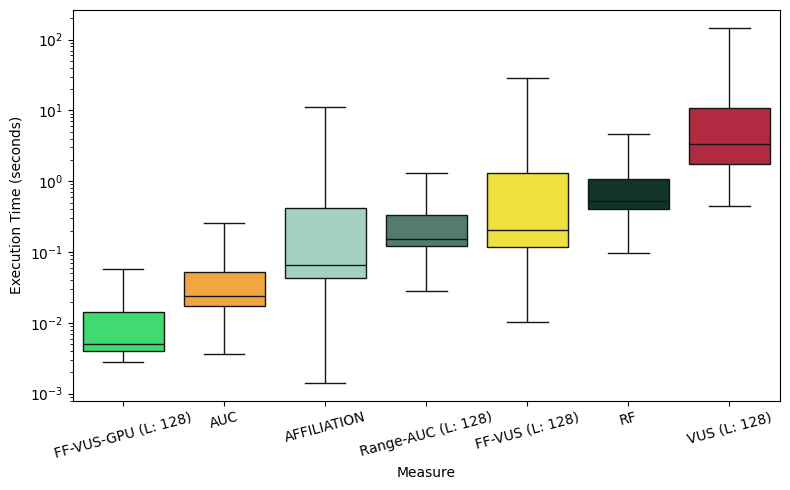

In [7]:
# TODO: Find why there is this big lines per metric, what affects this

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    saturation=1,
    # showmeans=True, 
    # meanline=True
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

Total number of time series: 540
Total number of points: 42981662720, 42981662k, 42981m, 42b
Length min: 1024, max: 2147483648
Number of anomalies min: 1, max: 385
Anomalies average length min: 1.0, max: 100000.0


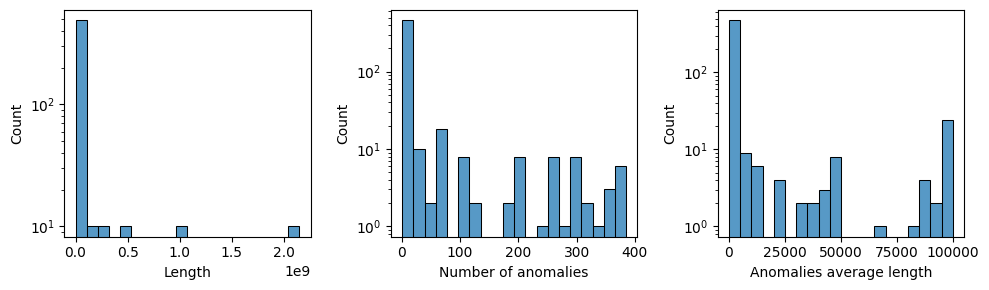

In [8]:
# Synthetic dataset insights
curr_df = df[df['Metric'] == 'AUC']
print(f"Total number of time series: {curr_df.shape[0]}")
print(f"Total number of points: {curr_df['Length'].sum()}, {curr_df['Length'].sum()//10**3}k, {curr_df['Length'].sum()//10**6}m, {curr_df['Length'].sum()//10**9}b")\

attributes = ["Length", "Number of anomalies", "Anomalies average length"]
attr_control = {}
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
bins = 20
for attr, axis in zip(attributes, ax):
    print(f"{attr} min: {curr_df[attr].min()}, max: {curr_df[attr].max()}")
    fig = sns.histplot(x=attr, data=curr_df, ax=axis, bins=bins)
    axis.set_yscale('log')
    axis.set_xlabel(attr)
plt.tight_layout()
plt.show()

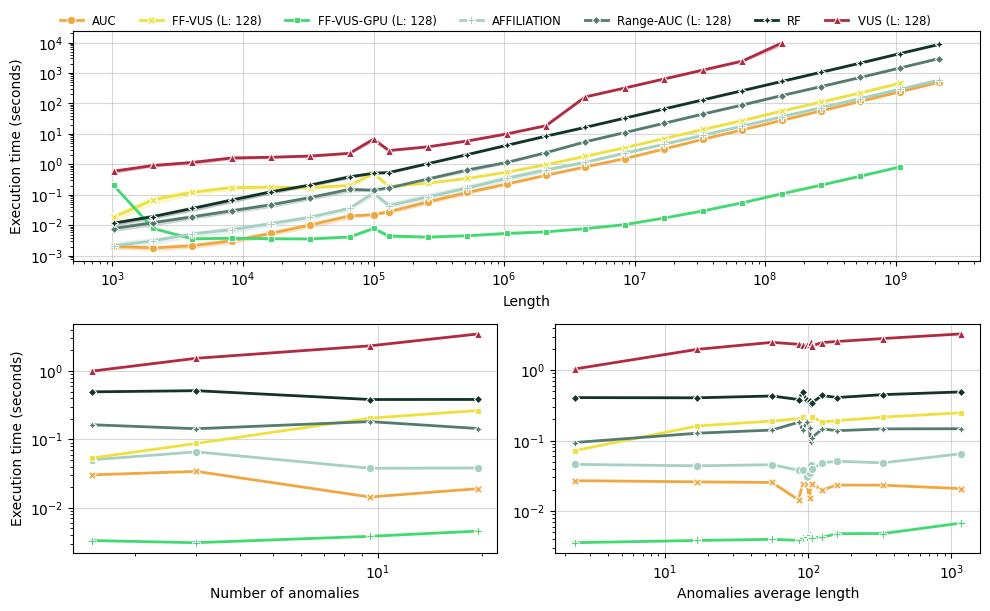

In [9]:
# TODO: Marker size increase
bins = 20
attr_control = {}
legend_axis = None
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4),
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    if attribute != 'Length':
        for attr in attributes:
            if attr != attribute:
                mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )
  
    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center' if attribute != 'Length' else 'Length',
        y='Metric time',
        hue='Metric',
        data=grouped if attribute != 'Length' else curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=2,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis


handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

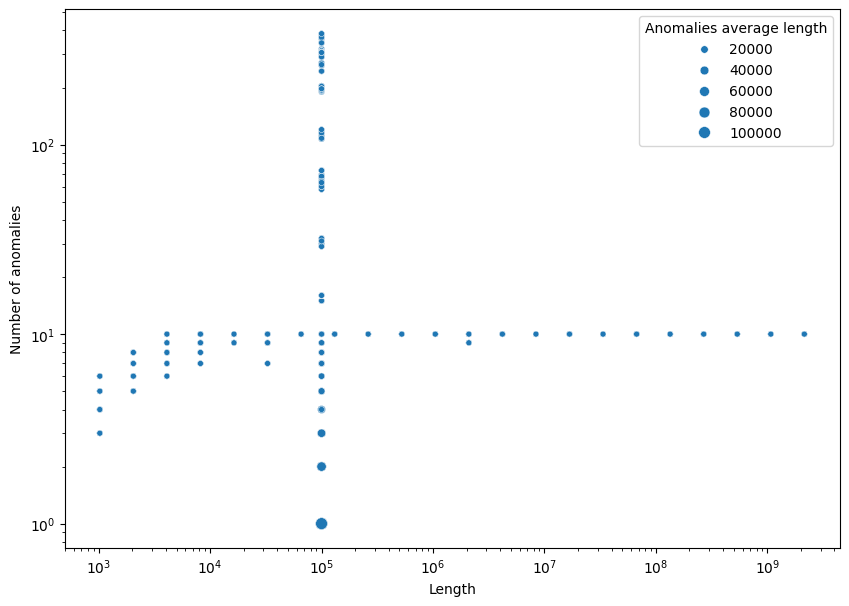

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

sns.scatterplot(
    data=df,
    x='Length',
    y='Number of anomalies',
    size='Anomalies average length',
    ax=ax
)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [11]:
tqdm.pandas()
def fix_ts_stats(row):
    parts = row['Time series'].split('_')
    row['Length'] = int(parts[1])
    row['Number of anomalies'] = int(parts[2])
    row['Anomalies average length'] = int(parts[3])
    row['Contamination'] = float((row['Number of anomalies'] * row['Anomalies average length']) / row['Length'])
    return row

df = df.progress_apply(fix_ts_stats, axis=1)
df

  0%|                                         | 1/3720 [00:00<00:15, 238.91it/s]


KeyError: 'Time series'

In [12]:
metrics = df['Metric'].unique()
contamination_values = np.sort(df['Contamination'].unique())[::-1]
length_mean_values = []
global_cont_values = [x for x in contamination_values]

for metric in metrics:
    curr_df = df[df['Metric'] == metric]
    length_values = np.sort(curr_df['Length'].unique())
    # print(f"For {metric}, {len(length_values)} lengths were computed: {length_values}")

    for length in length_values:
        cont_value_counts = curr_df[curr_df['Length'] == length]['Contamination'].value_counts()
        # if contamination_values[0] not in cont_value_counts.keys():
            
            # print(cont_value_counts.keys())
        for cont_value in global_cont_values:
            if cont_value not in cont_value_counts:
                global_cont_values.remove(cont_value)
            # if cont_value in cont_value_counts:
            #     length_mean_values.append({
            #         'Metric': metric,
            #         'Length': length,
            #         'Contamination': cont_value,
            #         'Mean execution time': curr_df[np.logical_and(curr_df['Length'] == length, curr_df['Contamination'] == cont_value)]['Metric time'].mean()
            #     })
            #     break
            # print(cont_value_counts.keys())
        # print(curr_df[curr_df['Length'] == length].shape)
        # print(cont_values[0.01])
# length_mean_df = pd.DataFrame(length_mean_values)
# print(length_mean_df)
global_cont_values

KeyError: 'Contamination'

In [13]:
for attr in ['Length', 'Number of anomalies', 'Anomalies average length', 'Contamination']:
    unique_attr_values = np.sort(df[attr].unique())
    print(f"{attr}: {unique_attr_values}")
# print(attributes)

Length: [      1024       2048       4096       8192      16384      32768
      65536     100000     131072     262144     524288    1048576
    2097152    4194304    8388608   16777216   33554432   67108864
  134217728  268435456  536870912 1073741824 2147483648]
Number of anomalies: [  1   2   3   4   5   6   7   8   9  10  15  16  29  30  31  32  58  59
  60  61  62  63  64  66  67  68  69  73 107 108 109 111 114 115 116 117
 120 190 192 193 194 197 198 200 203 204 244 261 263 264 265 266 267 269
 270 290 299 306 307 308 313 319 344 347 362 365 368 369 370 375 378 385]
Anomalies average length: [1.00000000e+00 2.00000000e+00 2.80000000e+00 3.00000000e+00
 3.40000000e+00 3.50000000e+00 3.60000000e+00 3.70000000e+00
 3.80000000e+00 4.20000000e+00 4.40000000e+00 5.90000000e+00
 7.00000000e+00 7.10000000e+00 7.20000000e+00 7.30000000e+00
 7.40000000e+00 7.50000000e+00 7.90000000e+00 8.00000000e+00
 9.20000000e+00 1.45000000e+01 1.47000000e+01 1.52000000e+01
 1.58000000e+01 1.63000000e+

KeyError: 'Contamination'

In [14]:

# TODO: Marker size increase
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    attr_control[attr] = df[attr].value_counts().idxmax()
attr_control

# attr_axis = {
#     "Length": (2, 1, 1), 
#     "Number of anomalies": (2, 2, 3), 
#     "Anomalies average length": (2, 2, 4)
# }
# fig = plt.figure(figsize=(10, 6))
# for i, attribute in enumerate(attributes):
#     axis = fig.add_subplot(*attr_axis[attribute])

#     mask = pd.Series(True, index=df.index)
#     if attribute != 'Length':
#         for attr in attributes:
#             if attr != attribute:
#                 mask &= (df[f'{attr} bin'] == attr_control[attr])
#     curr_df = df[mask]
    
#     # Group by bin and metric, compute mean
#     grouped = (
#         curr_df
#         .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
#         .mean()
#         .reset_index()
#     )
  
#     # Convert bin to the midpoint for plotting
#     grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

#     # Plot
#     sns.lineplot(
#         x='bin_center' if attribute != 'Length' else 'Length',
#         y='Metric time',
#         hue='Metric',
#         data=grouped if attribute != 'Length' else curr_df,
#         ax=axis,
#         palette=color_palette,
#         markers=True,
#         style='Metric',
#         dashes = False,
#         linewidth=2,
#         # size='Metric', 
#         # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
#     )

#     axis.set_xlabel(attribute)
#     axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
#     axis.set_yscale('log')
#     axis.set_xscale('log')
#     axis.grid(axis='both', alpha=0.5)
#     if i != 0: 
#         axis.get_legend().remove()

# plt.tight_layout()
# plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
# plt.show()

{'Length': 100000, 'Number of anomalies': 10, 'Anomalies average length': 1.0}